In [1]:
%matplotlib inline

# Radial velocity fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.6


In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

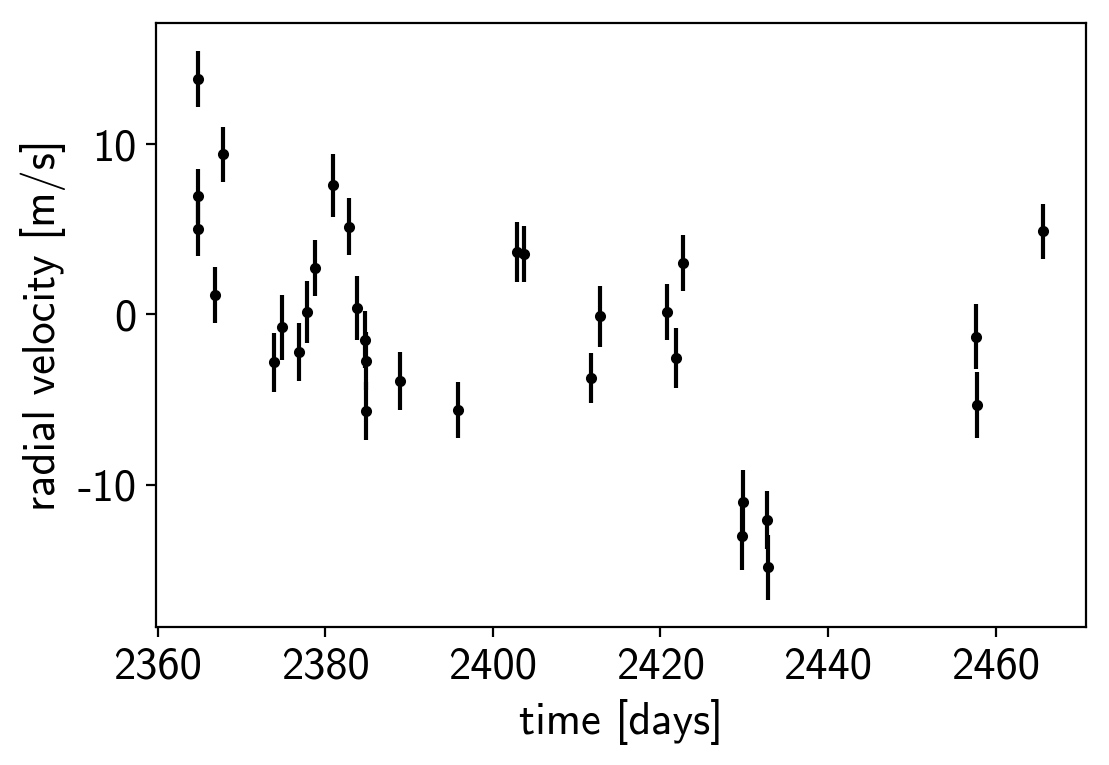

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Normal("P", mu=np.array(periods), sd=np.array(period_errs), shape=2)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=10.0, shape=2)
    
    # This is a sanity check that restricts the semiamplitude to reasonable
    # values because things can get ugly as K -> 0
    pm.Potential("logK_bound", tt.switch(logK < 0, -np.inf, 0.0))
    
    # We also want to keep period physical but this probably won't be hit
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Eccentricity & argument of periasteron
    ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, shape=2,
                  testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2)
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

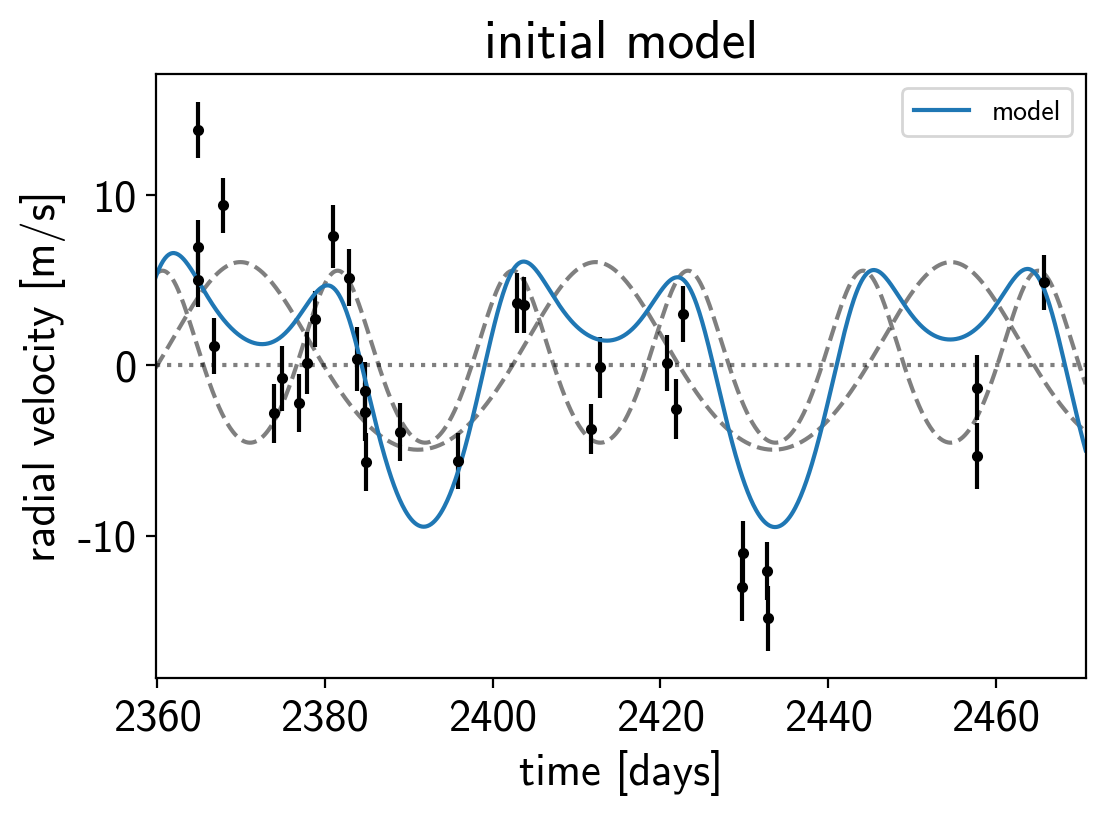

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -85.6487819642777 -> -70.76432173140458


optimizing logp for variables: ['trend', 'logs', 'omega_angle__', 'ecc_logodds__', 'logK', 'P', 't0']


message: Optimization terminated successfully.
logp: -70.76432173140458 -> -21.515004321664108


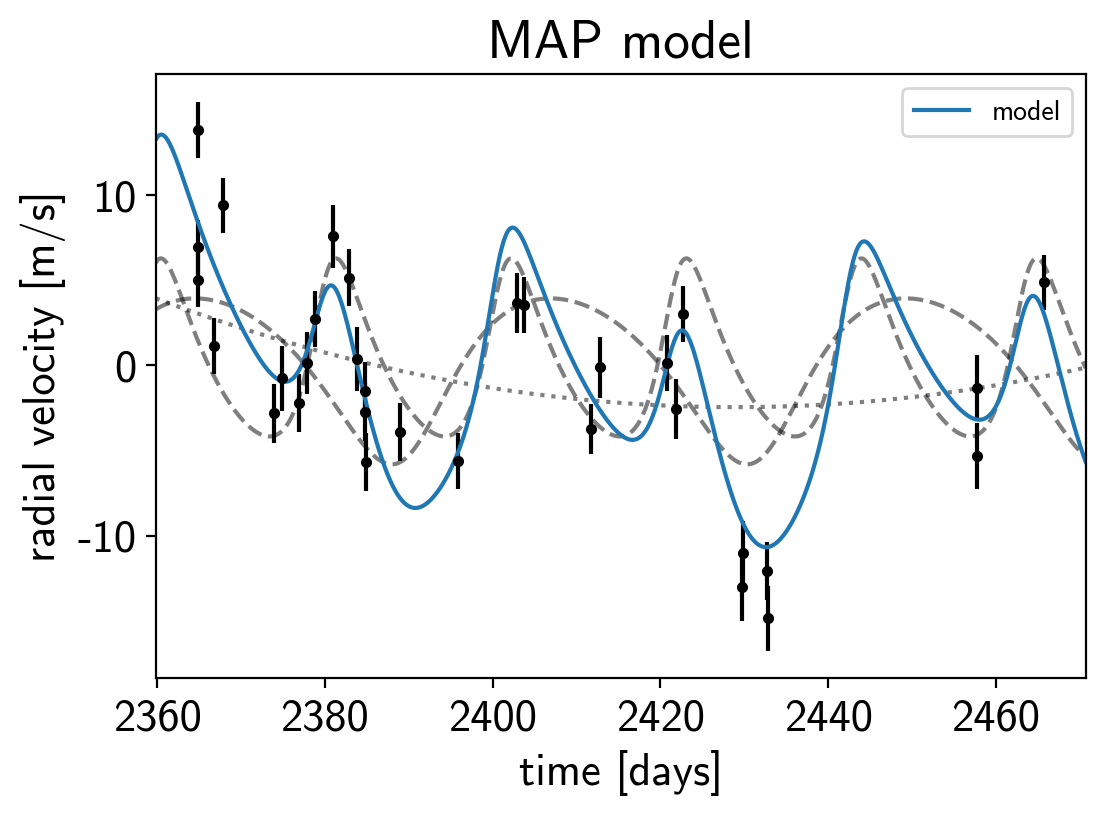

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :class:`exoplanet.PyMC3Sampler` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:03, 197.06draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:06, 123.04draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:00<00:07, 97.37draws/s] 

Sampling 4 chains:   5%|▌         | 43/808 [00:00<00:08, 89.84draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:00<00:08, 85.15draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:00<00:09, 82.18draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:00<00:09, 80.11draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:00<00:09, 78.85draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:00<00:09, 77.99draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:01<00:09, 73.61draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:01<00:09, 74.36draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:01<00:09, 74.93draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:01<00:09, 75.29draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:01<00:09, 75.59draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:01<00:09, 75.20draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:01<00:08, 75.02draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:01<00:08, 75.43draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:01<00:08, 75.70draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:02<00:08, 75.87draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:02<00:08, 76.08draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:02<00:08, 75.98draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:02<00:08, 75.20draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:02<00:08, 74.95draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:02<00:08, 75.10draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:02<00:07, 75.40draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:02<00:07, 75.24draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:02<00:07, 74.70draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:02<00:07, 74.80draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:03<00:07, 75.24draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:03<00:07, 74.91draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:03<00:07, 75.36draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:03<00:07, 75.69draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:03<00:07, 75.98draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:03<00:06, 76.19draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:03<00:06, 75.65draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:03<00:06, 76.00draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:03<00:06, 76.06draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:04<00:06, 75.96draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:04<00:06, 74.25draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:04<00:06, 74.99draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:04<00:06, 75.29draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:04<00:06, 75.45draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:04<00:06, 74.80draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:04<00:05, 74.90draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:04<00:05, 74.93draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:04<00:05, 75.02draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:05<00:05, 75.01draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:05<00:05, 74.99draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:05<00:05, 75.06draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:05<00:05, 75.08draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:05<00:05, 75.08draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:05<00:05, 75.08draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:05<00:04, 75.37draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:05<00:04, 75.85draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:05<00:04, 75.09draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:05<00:04, 74.98draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:06<00:04, 75.24draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:06<00:04, 75.64draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:06<00:04, 74.96draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [00:06<00:04, 75.09draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:06<00:04, 75.17draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:06<00:03, 75.26draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:06<00:03, 75.30draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:06<00:03, 75.30draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:06<00:03, 80.14draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:07<00:03, 74.53draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:07<00:03, 74.92draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:07<00:03, 75.53draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [00:07<00:03, 75.97draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:07<00:03, 76.26draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [00:07<00:02, 76.47draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:07<00:02, 76.64draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:07<00:02, 76.77draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:07<00:02, 76.87draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [00:08<00:02, 76.92draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:08<00:02, 76.94draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:08<00:02, 76.98draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:08<00:02, 76.98draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:08<00:02, 77.02draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:08<00:02, 75.93draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:08<00:01, 76.17draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:08<00:01, 76.12draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:08<00:01, 75.32draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:08<00:01, 73.97draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:09<00:01, 74.18draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:09<00:01, 74.37draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:09<00:01, 74.54draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:09<00:01, 75.01draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [00:09<00:01, 75.65draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [00:09<00:00, 76.09draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:09<00:00, 76.37draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:09<00:00, 76.15draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [00:09<00:00, 76.41draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:10<00:00, 76.13draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [00:10<00:00, 75.96draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:10<00:00, 75.88draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:10<00:00, 75.79draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:10<00:00, 62.60draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:10<00:00, 44.66draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:11<00:00, 73.20draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▍         | 19/408 [00:00<00:02, 183.85draws/s]

Sampling 4 chains:   6%|▋         | 26/408 [00:00<00:03, 118.70draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:03, 95.20draws/s] 

Sampling 4 chains:  10%|█         | 41/408 [00:00<00:04, 87.85draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:00<00:04, 86.65draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:00<00:04, 85.57draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:00<00:04, 82.08draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:00<00:03, 85.25draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:00<00:03, 84.75draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:01<00:03, 82.85draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:01<00:03, 82.79draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:01<00:03, 81.81draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:01<00:03, 82.64draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:01<00:03, 84.17draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:01<00:03, 81.67draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:01<00:03, 83.03draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:01<00:03, 82.15draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:01<00:03, 75.23draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:02<00:02, 79.48draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:02<00:02, 80.63draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:02<00:02, 81.20draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:02<00:02, 81.16draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:02<00:02, 80.43draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:02<00:02, 82.38draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:02<00:02, 80.90draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:02<00:02, 77.58draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:02<00:01, 81.62draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:03<00:01, 82.67draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:03<00:01, 82.49draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:03<00:01, 82.82draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:03<00:01, 82.20draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:03<00:01, 84.23draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:03<00:01, 80.55draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:03<00:01, 79.28draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:03<00:01, 77.58draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:03<00:01, 77.24draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:04<00:00, 76.59draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:04<00:00, 78.04draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:04<00:00, 77.36draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:04<00:00, 76.35draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:04<00:00, 76.21draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:04<00:00, 78.76draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:04<00:00, 77.89draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:04<00:00, 76.36draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:05<00:00, 57.15draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:05<00:00, 75.38draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:08, 91.73draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:00<00:08, 87.72draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:00<00:09, 85.19draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:00<00:08, 90.19draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:00<00:07, 99.26draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:00<00:06, 108.71draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:00<00:05, 124.76draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:00<00:05, 127.08draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:00<00:04, 137.34draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:01<00:04, 151.95draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:01<00:04, 156.85draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:01<00:03, 167.14draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:01<00:03, 188.12draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:01<00:02, 194.58draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:01<00:02, 200.33draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:01<00:02, 198.43draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:01<00:02, 189.73draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:01<00:02, 184.78draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:02<00:02, 182.83draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:02<00:02, 190.04draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:02<00:02, 206.21draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:02<00:01, 203.74draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:02<00:02, 192.19draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:02<00:01, 202.34draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:02<00:01, 199.08draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:02<00:01, 198.87draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:02<00:01, 210.83draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [00:03<00:01, 212.21draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:03<00:01, 189.53draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [00:03<00:01, 198.05draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:03<00:01, 199.18draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [00:03<00:00, 200.28draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:03<00:00, 219.93draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:03<00:00, 202.97draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:03<00:00, 188.52draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:04<00:00, 167.60draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:04<00:00, 171.58draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:04<00:00, 166.20draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:04<00:00, 164.49draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:04<00:00, 147.10draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:04<00:00, 114.85draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:04<00:00, 169.21draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:00<00:04, 357.51draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:00<00:04, 367.68draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:00<00:04, 372.25draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:00<00:03, 381.30draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:00<00:03, 374.45draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [00:00<00:03, 410.51draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:00<00:02, 447.45draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:00<00:02, 456.46draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [00:00<00:02, 462.24draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [00:01<00:02, 465.28draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [00:01<00:02, 464.38draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [00:01<00:02, 485.84draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [00:01<00:01, 508.59draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [00:01<00:01, 527.95draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [00:01<00:01, 459.00draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [00:01<00:01, 443.90draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [00:01<00:01, 467.08draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [00:01<00:01, 470.61draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [00:01<00:01, 466.20draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [00:02<00:01, 444.77draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [00:02<00:01, 409.54draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [00:02<00:01, 410.13draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [00:02<00:01, 439.70draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [00:02<00:00, 472.42draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [00:02<00:00, 474.46draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [00:02<00:00, 472.41draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [00:02<00:00, 470.23draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [00:02<00:00, 452.30draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [00:03<00:00, 469.60draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [00:03<00:00, 487.91draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [00:03<00:00, 379.76draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [00:03<00:00, 332.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [00:03<00:00, 247.49draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 414.22draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:00<00:07, 403.47draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:00<00:07, 415.22draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:00<00:06, 449.72draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:00<00:06, 473.07draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:00<00:06, 484.10draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:00<00:05, 492.64draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:00<00:06, 466.95draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [00:00<00:06, 461.59draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [00:00<00:06, 455.15draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [00:01<00:05, 476.44draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [00:01<00:05, 469.19draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [00:01<00:05, 457.53draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [00:01<00:05, 468.86draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [00:01<00:05, 487.08draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [00:01<00:04, 506.96draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [00:01<00:04, 496.87draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [00:01<00:04, 511.69draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [00:01<00:04, 514.57draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [00:01<00:04, 531.88draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [00:02<00:04, 526.26draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [00:02<00:03, 536.26draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [00:02<00:03, 543.99draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [00:02<00:03, 529.49draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [00:02<00:03, 510.69draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [00:02<00:03, 515.29draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [00:02<00:03, 514.79draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [00:02<00:03, 511.94draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [00:02<00:03, 515.23draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [00:03<00:03, 475.97draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [00:03<00:03, 468.47draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [00:03<00:03, 480.92draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [00:03<00:03, 484.40draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [00:03<00:02, 499.56draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [00:03<00:02, 492.71draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [00:03<00:02, 504.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [00:03<00:02, 510.95draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [00:03<00:02, 521.66draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [00:03<00:02, 503.71draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [00:04<00:02, 504.94draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [00:04<00:02, 522.88draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [00:04<00:02, 527.24draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [00:04<00:01, 534.49draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [00:04<00:01, 530.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [00:04<00:01, 531.68draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [00:04<00:01, 479.74draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [00:04<00:01, 476.02draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [00:04<00:01, 483.55draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [00:05<00:01, 493.69draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [00:05<00:01, 513.55draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [00:05<00:01, 512.30draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [00:05<00:01, 517.50draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [00:05<00:00, 529.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [00:05<00:00, 534.38draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [00:05<00:00, 525.02draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [00:05<00:00, 514.17draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [00:05<00:00, 526.83draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [00:05<00:00, 466.10draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [00:06<00:00, 441.89draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [00:06<00:00, 285.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [00:06<00:00, 221.07draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [00:06<00:00, 181.62draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [00:07<00:00, 158.28draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:07<00:00, 443.05draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 36/9208 [00:00<00:25, 356.81draws/s]

Sampling 4 chains:   1%|          | 74/9208 [00:00<00:25, 361.43draws/s]

Sampling 4 chains:   1%|▏         | 118/9208 [00:00<00:23, 380.62draws/s]

Sampling 4 chains:   2%|▏         | 171/9208 [00:00<00:21, 413.83draws/s]

Sampling 4 chains:   3%|▎         | 231/9208 [00:00<00:19, 454.06draws/s]

Sampling 4 chains:   3%|▎         | 283/9208 [00:00<00:18, 470.04draws/s]

Sampling 4 chains:   4%|▎         | 331/9208 [00:00<00:18, 470.35draws/s]

Sampling 4 chains:   4%|▍         | 378/9208 [00:00<00:18, 468.16draws/s]

Sampling 4 chains:   5%|▍         | 428/9208 [00:00<00:18, 475.85draws/s]

Sampling 4 chains:   5%|▌         | 479/9208 [00:01<00:18, 484.67draws/s]

Sampling 4 chains:   6%|▌         | 532/9208 [00:01<00:17, 496.45draws/s]

Sampling 4 chains:   6%|▋         | 586/9208 [00:01<00:16, 507.82draws/s]

Sampling 4 chains:   7%|▋         | 637/9208 [00:01<00:17, 488.55draws/s]

Sampling 4 chains:   7%|▋         | 690/9208 [00:01<00:17, 497.10draws/s]

Sampling 4 chains:   8%|▊         | 750/9208 [00:01<00:16, 521.88draws/s]

Sampling 4 chains:   9%|▉         | 809/9208 [00:01<00:15, 538.18draws/s]

Sampling 4 chains:   9%|▉         | 864/9208 [00:01<00:15, 525.93draws/s]

Sampling 4 chains:  10%|▉         | 917/9208 [00:01<00:16, 514.09draws/s]

Sampling 4 chains:  11%|█         | 969/9208 [00:01<00:16, 512.81draws/s]

Sampling 4 chains:  11%|█         | 1023/9208 [00:02<00:15, 518.55draws/s]

Sampling 4 chains:  12%|█▏        | 1076/9208 [00:02<00:15, 515.51draws/s]

Sampling 4 chains:  12%|█▏        | 1128/9208 [00:02<00:15, 516.55draws/s]

Sampling 4 chains:  13%|█▎        | 1180/9208 [00:02<00:15, 513.73draws/s]

Sampling 4 chains:  13%|█▎        | 1232/9208 [00:02<00:15, 513.54draws/s]

Sampling 4 chains:  14%|█▍        | 1284/9208 [00:02<00:15, 505.67draws/s]

Sampling 4 chains:  15%|█▍        | 1339/9208 [00:02<00:15, 517.24draws/s]

Sampling 4 chains:  15%|█▌        | 1393/9208 [00:02<00:14, 523.01draws/s]

Sampling 4 chains:  16%|█▌        | 1446/9208 [00:02<00:14, 518.75draws/s]

Sampling 4 chains:  16%|█▋        | 1498/9208 [00:02<00:15, 507.12draws/s]

Sampling 4 chains:  17%|█▋        | 1550/9208 [00:03<00:14, 510.70draws/s]

Sampling 4 chains:  17%|█▋        | 1606/9208 [00:03<00:14, 523.55draws/s]

Sampling 4 chains:  18%|█▊        | 1664/9208 [00:03<00:14, 535.88draws/s]

Sampling 4 chains:  19%|█▊        | 1718/9208 [00:03<00:14, 531.01draws/s]

Sampling 4 chains:  19%|█▉        | 1776/9208 [00:03<00:13, 544.62draws/s]

Sampling 4 chains:  20%|█▉        | 1831/9208 [00:03<00:13, 544.63draws/s]

Sampling 4 chains:  20%|██        | 1886/9208 [00:03<00:13, 542.32draws/s]

Sampling 4 chains:  21%|██        | 1941/9208 [00:03<00:14, 516.60draws/s]

Sampling 4 chains:  22%|██▏       | 1993/9208 [00:03<00:14, 514.18draws/s]

Sampling 4 chains:  22%|██▏       | 2052/9208 [00:04<00:13, 532.75draws/s]

Sampling 4 chains:  23%|██▎       | 2108/9208 [00:04<00:13, 539.41draws/s]

Sampling 4 chains:  24%|██▎       | 2167/9208 [00:04<00:12, 552.21draws/s]

Sampling 4 chains:  24%|██▍       | 2223/9208 [00:04<00:12, 544.40draws/s]

Sampling 4 chains:  25%|██▍       | 2278/9208 [00:04<00:13, 529.82draws/s]

Sampling 4 chains:  25%|██▌       | 2332/9208 [00:04<00:13, 513.74draws/s]

Sampling 4 chains:  26%|██▌       | 2384/9208 [00:04<00:13, 509.64draws/s]

Sampling 4 chains:  26%|██▋       | 2436/9208 [00:04<00:14, 475.35draws/s]

Sampling 4 chains:  27%|██▋       | 2486/9208 [00:04<00:13, 481.02draws/s]

Sampling 4 chains:  28%|██▊       | 2536/9208 [00:04<00:13, 484.36draws/s]

Sampling 4 chains:  28%|██▊       | 2588/9208 [00:05<00:13, 492.98draws/s]

Sampling 4 chains:  29%|██▊       | 2640/9208 [00:05<00:13, 499.44draws/s]

Sampling 4 chains:  29%|██▉       | 2691/9208 [00:05<00:13, 497.54draws/s]

Sampling 4 chains:  30%|██▉       | 2742/9208 [00:05<00:12, 500.53draws/s]

Sampling 4 chains:  30%|███       | 2793/9208 [00:05<00:13, 492.95draws/s]

Sampling 4 chains:  31%|███       | 2843/9208 [00:05<00:12, 494.75draws/s]

Sampling 4 chains:  31%|███▏      | 2897/9208 [00:05<00:12, 504.55draws/s]

Sampling 4 chains:  32%|███▏      | 2951/9208 [00:05<00:12, 513.24draws/s]

Sampling 4 chains:  33%|███▎      | 3005/9208 [00:05<00:11, 518.59draws/s]

Sampling 4 chains:  33%|███▎      | 3062/9208 [00:05<00:11, 532.74draws/s]

Sampling 4 chains:  34%|███▍      | 3116/9208 [00:06<00:11, 534.29draws/s]

Sampling 4 chains:  34%|███▍      | 3175/9208 [00:06<00:10, 548.58draws/s]

Sampling 4 chains:  35%|███▌      | 3231/9208 [00:06<00:10, 547.52draws/s]

Sampling 4 chains:  36%|███▌      | 3287/9208 [00:06<00:10, 548.36draws/s]

Sampling 4 chains:  36%|███▋      | 3349/9208 [00:06<00:10, 566.66draws/s]

Sampling 4 chains:  37%|███▋      | 3406/9208 [00:06<00:10, 541.28draws/s]

Sampling 4 chains:  38%|███▊      | 3463/9208 [00:06<00:10, 548.31draws/s]

Sampling 4 chains:  38%|███▊      | 3519/9208 [00:06<00:10, 548.65draws/s]

Sampling 4 chains:  39%|███▉      | 3575/9208 [00:06<00:10, 545.25draws/s]

Sampling 4 chains:  39%|███▉      | 3630/9208 [00:07<00:10, 544.00draws/s]

Sampling 4 chains:  40%|████      | 3685/9208 [00:07<00:10, 526.91draws/s]

Sampling 4 chains:  41%|████      | 3738/9208 [00:07<00:10, 524.42draws/s]

Sampling 4 chains:  41%|████      | 3794/9208 [00:07<00:10, 531.29draws/s]

Sampling 4 chains:  42%|████▏     | 3848/9208 [00:07<00:10, 521.86draws/s]

Sampling 4 chains:  42%|████▏     | 3901/9208 [00:07<00:10, 515.95draws/s]

Sampling 4 chains:  43%|████▎     | 3957/9208 [00:07<00:09, 526.20draws/s]

Sampling 4 chains:  44%|████▎     | 4012/9208 [00:07<00:09, 529.44draws/s]

Sampling 4 chains:  44%|████▍     | 4067/9208 [00:07<00:09, 534.77draws/s]

Sampling 4 chains:  45%|████▍     | 4124/9208 [00:07<00:09, 544.62draws/s]

Sampling 4 chains:  45%|████▌     | 4181/9208 [00:08<00:09, 550.67draws/s]

Sampling 4 chains:  46%|████▌     | 4237/9208 [00:08<00:09, 547.73draws/s]

Sampling 4 chains:  47%|████▋     | 4294/9208 [00:08<00:08, 551.66draws/s]

Sampling 4 chains:  47%|████▋     | 4354/9208 [00:08<00:08, 559.95draws/s]

Sampling 4 chains:  48%|████▊     | 4411/9208 [00:08<00:09, 526.90draws/s]

Sampling 4 chains:  48%|████▊     | 4465/9208 [00:08<00:09, 489.48draws/s]

Sampling 4 chains:  49%|████▉     | 4515/9208 [00:08<00:10, 459.19draws/s]

Sampling 4 chains:  50%|████▉     | 4562/9208 [00:08<00:10, 460.77draws/s]

Sampling 4 chains:  50%|█████     | 4612/9208 [00:08<00:09, 469.76draws/s]

Sampling 4 chains:  51%|█████     | 4664/9208 [00:09<00:09, 482.66draws/s]

Sampling 4 chains:  51%|█████     | 4714/9208 [00:09<00:09, 484.44draws/s]

Sampling 4 chains:  52%|█████▏    | 4764/9208 [00:09<00:09, 487.91draws/s]

Sampling 4 chains:  52%|█████▏    | 4821/9208 [00:09<00:08, 509.19draws/s]

Sampling 4 chains:  53%|█████▎    | 4875/9208 [00:09<00:08, 516.43draws/s]

Sampling 4 chains:  54%|█████▎    | 4934/9208 [00:09<00:07, 535.47draws/s]

Sampling 4 chains:  54%|█████▍    | 4988/9208 [00:09<00:07, 533.28draws/s]

Sampling 4 chains:  55%|█████▍    | 5042/9208 [00:09<00:08, 512.11draws/s]

Sampling 4 chains:  55%|█████▌    | 5094/9208 [00:09<00:08, 502.13draws/s]

Sampling 4 chains:  56%|█████▌    | 5145/9208 [00:09<00:08, 496.58draws/s]

Sampling 4 chains:  56%|█████▋    | 5198/9208 [00:10<00:07, 504.47draws/s]

Sampling 4 chains:  57%|█████▋    | 5253/9208 [00:10<00:07, 516.53draws/s]

Sampling 4 chains:  58%|█████▊    | 5312/9208 [00:10<00:07, 534.11draws/s]

Sampling 4 chains:  58%|█████▊    | 5369/9208 [00:10<00:07, 541.05draws/s]

Sampling 4 chains:  59%|█████▉    | 5424/9208 [00:10<00:06, 541.67draws/s]

Sampling 4 chains:  60%|█████▉    | 5482/9208 [00:10<00:06, 551.92draws/s]

Sampling 4 chains:  60%|██████    | 5540/9208 [00:10<00:06, 559.65draws/s]

Sampling 4 chains:  61%|██████    | 5597/9208 [00:10<00:06, 557.27draws/s]

Sampling 4 chains:  61%|██████▏   | 5653/9208 [00:10<00:06, 549.54draws/s]

Sampling 4 chains:  62%|██████▏   | 5710/9208 [00:11<00:06, 553.16draws/s]

Sampling 4 chains:  63%|██████▎   | 5768/9208 [00:11<00:06, 558.20draws/s]

Sampling 4 chains:  63%|██████▎   | 5824/9208 [00:11<00:06, 556.87draws/s]

Sampling 4 chains:  64%|██████▍   | 5882/9208 [00:11<00:05, 561.81draws/s]

Sampling 4 chains:  65%|██████▍   | 5940/9208 [00:11<00:05, 564.18draws/s]

Sampling 4 chains:  65%|██████▌   | 5998/9208 [00:11<00:05, 566.54draws/s]

Sampling 4 chains:  66%|██████▌   | 6055/9208 [00:11<00:05, 558.25draws/s]

Sampling 4 chains:  66%|██████▋   | 6111/9208 [00:11<00:05, 555.81draws/s]

Sampling 4 chains:  67%|██████▋   | 6167/9208 [00:11<00:05, 528.33draws/s]

Sampling 4 chains:  68%|██████▊   | 6221/9208 [00:11<00:05, 500.80draws/s]

Sampling 4 chains:  68%|██████▊   | 6272/9208 [00:12<00:06, 486.45draws/s]

Sampling 4 chains:  69%|██████▊   | 6323/9208 [00:12<00:05, 491.59draws/s]

Sampling 4 chains:  69%|██████▉   | 6373/9208 [00:12<00:05, 489.24draws/s]

Sampling 4 chains:  70%|██████▉   | 6428/9208 [00:12<00:05, 503.63draws/s]

Sampling 4 chains:  70%|███████   | 6480/9208 [00:12<00:05, 508.26draws/s]

Sampling 4 chains:  71%|███████   | 6532/9208 [00:12<00:05, 508.63draws/s]

Sampling 4 chains:  72%|███████▏  | 6585/9208 [00:12<00:05, 510.59draws/s]

Sampling 4 chains:  72%|███████▏  | 6640/9208 [00:12<00:04, 521.04draws/s]

Sampling 4 chains:  73%|███████▎  | 6698/9208 [00:12<00:04, 535.81draws/s]

Sampling 4 chains:  73%|███████▎  | 6757/9208 [00:12<00:04, 549.68draws/s]

Sampling 4 chains:  74%|███████▍  | 6820/9208 [00:13<00:04, 571.27draws/s]

Sampling 4 chains:  75%|███████▍  | 6882/9208 [00:13<00:03, 582.09draws/s]

Sampling 4 chains:  75%|███████▌  | 6941/9208 [00:13<00:04, 552.20draws/s]

Sampling 4 chains:  76%|███████▌  | 6997/9208 [00:13<00:04, 534.23draws/s]

Sampling 4 chains:  77%|███████▋  | 7055/9208 [00:13<00:03, 546.18draws/s]

Sampling 4 chains:  77%|███████▋  | 7111/9208 [00:13<00:03, 548.73draws/s]

Sampling 4 chains:  78%|███████▊  | 7167/9208 [00:13<00:03, 542.41draws/s]

Sampling 4 chains:  78%|███████▊  | 7224/9208 [00:13<00:03, 547.95draws/s]

Sampling 4 chains:  79%|███████▉  | 7281/9208 [00:13<00:03, 553.17draws/s]

Sampling 4 chains:  80%|███████▉  | 7338/9208 [00:14<00:03, 556.24draws/s]

Sampling 4 chains:  80%|████████  | 7397/9208 [00:14<00:03, 563.29draws/s]

Sampling 4 chains:  81%|████████  | 7454/9208 [00:14<00:03, 551.65draws/s]

Sampling 4 chains:  82%|████████▏ | 7510/9208 [00:14<00:03, 547.78draws/s]

Sampling 4 chains:  82%|████████▏ | 7565/9208 [00:14<00:03, 547.61draws/s]

Sampling 4 chains:  83%|████████▎ | 7623/9208 [00:14<00:02, 555.08draws/s]

Sampling 4 chains:  83%|████████▎ | 7680/9208 [00:14<00:02, 558.59draws/s]

Sampling 4 chains:  84%|████████▍ | 7736/9208 [00:14<00:02, 551.16draws/s]

Sampling 4 chains:  85%|████████▍ | 7792/9208 [00:14<00:02, 539.01draws/s]

Sampling 4 chains:  85%|████████▌ | 7847/9208 [00:14<00:02, 531.58draws/s]

Sampling 4 chains:  86%|████████▌ | 7902/9208 [00:15<00:02, 533.70draws/s]

Sampling 4 chains:  86%|████████▋ | 7956/9208 [00:15<00:02, 530.39draws/s]

Sampling 4 chains:  87%|████████▋ | 8010/9208 [00:15<00:02, 514.87draws/s]

Sampling 4 chains:  88%|████████▊ | 8062/9208 [00:15<00:02, 514.35draws/s]

Sampling 4 chains:  88%|████████▊ | 8114/9208 [00:15<00:02, 504.14draws/s]

Sampling 4 chains:  89%|████████▊ | 8165/9208 [00:15<00:02, 443.61draws/s]

Sampling 4 chains:  89%|████████▉ | 8211/9208 [00:15<00:02, 428.02draws/s]

Sampling 4 chains:  90%|████████▉ | 8259/9208 [00:15<00:02, 438.92draws/s]

Sampling 4 chains:  90%|█████████ | 8307/9208 [00:15<00:02, 449.51draws/s]

Sampling 4 chains:  91%|█████████ | 8353/9208 [00:16<00:01, 448.97draws/s]

Sampling 4 chains:  91%|█████████▏| 8403/9208 [00:16<00:01, 461.98draws/s]

Sampling 4 chains:  92%|█████████▏| 8455/9208 [00:16<00:01, 476.94draws/s]

Sampling 4 chains:  92%|█████████▏| 8509/9208 [00:16<00:01, 491.53draws/s]

Sampling 4 chains:  93%|█████████▎| 8562/9208 [00:16<00:01, 501.92draws/s]

Sampling 4 chains:  94%|█████████▎| 8613/9208 [00:16<00:01, 492.40draws/s]

Sampling 4 chains:  94%|█████████▍| 8668/9208 [00:16<00:01, 506.92draws/s]

Sampling 4 chains:  95%|█████████▍| 8719/9208 [00:16<00:01, 438.36draws/s]

Sampling 4 chains:  95%|█████████▌| 8765/9208 [00:16<00:01, 426.38draws/s]

Sampling 4 chains:  96%|█████████▌| 8810/9208 [00:17<00:01, 387.57draws/s]

Sampling 4 chains:  96%|█████████▌| 8851/9208 [00:17<00:01, 354.34draws/s]

Sampling 4 chains:  97%|█████████▋| 8889/9208 [00:17<00:00, 326.10draws/s]

Sampling 4 chains:  97%|█████████▋| 8924/9208 [00:17<00:00, 327.30draws/s]

Sampling 4 chains:  97%|█████████▋| 8958/9208 [00:17<00:00, 313.93draws/s]

Sampling 4 chains:  98%|█████████▊| 8991/9208 [00:17<00:00, 301.38draws/s]

Sampling 4 chains:  98%|█████████▊| 9022/9208 [00:17<00:00, 294.20draws/s]

Sampling 4 chains:  98%|█████████▊| 9052/9208 [00:18<00:00, 232.97draws/s]

Sampling 4 chains:  99%|█████████▊| 9078/9208 [00:18<00:00, 199.97draws/s]

Sampling 4 chains:  99%|█████████▉| 9101/9208 [00:18<00:00, 172.73draws/s]

Sampling 4 chains:  99%|█████████▉| 9121/9208 [00:18<00:00, 156.41draws/s]

Sampling 4 chains:  99%|█████████▉| 9139/9208 [00:18<00:00, 140.63draws/s]

Sampling 4 chains:  99%|█████████▉| 9155/9208 [00:18<00:00, 139.62draws/s]

Sampling 4 chains: 100%|█████████▉| 9172/9208 [00:18<00:00, 145.00draws/s]

Sampling 4 chains: 100%|█████████▉| 9188/9208 [00:19<00:00, 145.16draws/s]

Sampling 4 chains: 100%|█████████▉| 9205/9208 [00:19<00:00, 148.71draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:19<00:00, 480.22draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 39/1208 [00:00<00:03, 388.26draws/s]

Sampling 4 chains:   6%|▋         | 77/1208 [00:00<00:02, 383.86draws/s]

Sampling 4 chains:   9%|▊         | 105/1208 [00:00<00:03, 343.25draws/s]

Sampling 4 chains:  12%|█▏        | 150/1208 [00:00<00:02, 368.72draws/s]

Sampling 4 chains:  17%|█▋        | 202/1208 [00:00<00:02, 402.83draws/s]

Sampling 4 chains:  21%|██▏       | 258/1208 [00:00<00:02, 438.36draws/s]

Sampling 4 chains:  26%|██▌       | 312/1208 [00:00<00:01, 462.31draws/s]

Sampling 4 chains:  30%|██▉       | 361/1208 [00:00<00:01, 465.81draws/s]

Sampling 4 chains:  34%|███▍      | 409/1208 [00:00<00:01, 468.49draws/s]

Sampling 4 chains:  39%|███▊      | 467/1208 [00:01<00:01, 496.46draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [00:01<00:01, 513.96draws/s]

Sampling 4 chains:  48%|████▊     | 575/1208 [00:01<00:01, 480.14draws/s]

Sampling 4 chains:  52%|█████▏    | 624/1208 [00:01<00:01, 454.39draws/s]

Sampling 4 chains:  56%|█████▌    | 672/1208 [00:01<00:01, 459.36draws/s]

Sampling 4 chains:  60%|█████▉    | 719/1208 [00:01<00:01, 446.57draws/s]

Sampling 4 chains:  63%|██████▎   | 765/1208 [00:01<00:00, 448.99draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [00:01<00:00, 441.27draws/s]

Sampling 4 chains:  71%|███████▏  | 863/1208 [00:01<00:00, 460.91draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [00:01<00:00, 483.30draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [00:02<00:00, 496.95draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [00:02<00:00, 497.72draws/s]

Sampling 4 chains:  90%|████████▉ | 1082/1208 [00:02<00:00, 521.54draws/s]

Sampling 4 chains:  94%|█████████▍| 1135/1208 [00:02<00:00, 496.92draws/s]

Sampling 4 chains:  98%|█████████▊| 1186/1208 [00:02<00:00, 427.90draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:02<00:00, 445.74draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 40/16000 [00:00<00:40, 391.14draws/s]

Sampling 4 chains:   1%|          | 93/16000 [00:00<00:37, 422.94draws/s]

Sampling 4 chains:   1%|          | 148/16000 [00:00<00:34, 453.70draws/s]

Sampling 4 chains:   1%|▏         | 204/16000 [00:00<00:32, 479.24draws/s]

Sampling 4 chains:   2%|▏         | 260/16000 [00:00<00:31, 500.26draws/s]

Sampling 4 chains:   2%|▏         | 315/16000 [00:00<00:30, 510.51draws/s]

Sampling 4 chains:   2%|▏         | 371/16000 [00:00<00:29, 522.89draws/s]

Sampling 4 chains:   3%|▎         | 425/16000 [00:00<00:29, 526.67draws/s]

Sampling 4 chains:   3%|▎         | 485/16000 [00:00<00:28, 543.73draws/s]

Sampling 4 chains:   3%|▎         | 539/16000 [00:01<00:29, 528.26draws/s]

Sampling 4 chains:   4%|▎         | 595/16000 [00:01<00:28, 537.30draws/s]

Sampling 4 chains:   4%|▍         | 653/16000 [00:01<00:28, 547.07draws/s]

Sampling 4 chains:   4%|▍         | 708/16000 [00:01<00:28, 544.09draws/s]

Sampling 4 chains:   5%|▍         | 763/16000 [00:01<00:27, 544.53draws/s]

Sampling 4 chains:   5%|▌         | 818/16000 [00:01<00:27, 545.00draws/s]

Sampling 4 chains:   5%|▌         | 873/16000 [00:01<00:28, 539.26draws/s]

Sampling 4 chains:   6%|▌         | 928/16000 [00:01<00:27, 540.76draws/s]

Sampling 4 chains:   6%|▌         | 983/16000 [00:01<00:27, 536.46draws/s]

Sampling 4 chains:   7%|▋         | 1043/16000 [00:01<00:27, 548.64draws/s]

Sampling 4 chains:   7%|▋         | 1101/16000 [00:02<00:26, 556.56draws/s]

Sampling 4 chains:   7%|▋         | 1157/16000 [00:02<00:26, 555.40draws/s]

Sampling 4 chains:   8%|▊         | 1214/16000 [00:02<00:26, 559.67draws/s]

Sampling 4 chains:   8%|▊         | 1271/16000 [00:02<00:26, 555.21draws/s]

Sampling 4 chains:   8%|▊         | 1328/16000 [00:02<00:26, 559.39draws/s]

Sampling 4 chains:   9%|▊         | 1384/16000 [00:02<00:26, 556.21draws/s]

Sampling 4 chains:   9%|▉         | 1440/16000 [00:02<00:26, 553.30draws/s]

Sampling 4 chains:   9%|▉         | 1496/16000 [00:02<00:26, 545.95draws/s]

Sampling 4 chains:  10%|▉         | 1551/16000 [00:02<00:26, 544.89draws/s]

Sampling 4 chains:  10%|█         | 1607/16000 [00:02<00:26, 547.17draws/s]

Sampling 4 chains:  10%|█         | 1662/16000 [00:03<00:26, 538.23draws/s]

Sampling 4 chains:  11%|█         | 1718/16000 [00:03<00:26, 543.02draws/s]

Sampling 4 chains:  11%|█         | 1773/16000 [00:03<00:26, 539.62draws/s]

Sampling 4 chains:  11%|█▏        | 1830/16000 [00:03<00:25, 546.00draws/s]

Sampling 4 chains:  12%|█▏        | 1887/16000 [00:03<00:25, 552.16draws/s]

Sampling 4 chains:  12%|█▏        | 1946/16000 [00:03<00:24, 562.55draws/s]

Sampling 4 chains:  13%|█▎        | 2003/16000 [00:03<00:25, 548.63draws/s]

Sampling 4 chains:  13%|█▎        | 2058/16000 [00:03<00:25, 540.10draws/s]

Sampling 4 chains:  13%|█▎        | 2113/16000 [00:03<00:26, 529.12draws/s]

Sampling 4 chains:  14%|█▎        | 2167/16000 [00:04<00:26, 526.68draws/s]

Sampling 4 chains:  14%|█▍        | 2225/16000 [00:04<00:25, 539.84draws/s]

Sampling 4 chains:  14%|█▍        | 2280/16000 [00:04<00:25, 539.04draws/s]

Sampling 4 chains:  15%|█▍        | 2340/16000 [00:04<00:24, 554.41draws/s]

Sampling 4 chains:  15%|█▍        | 2396/16000 [00:04<00:24, 544.16draws/s]

Sampling 4 chains:  15%|█▌        | 2457/16000 [00:04<00:24, 561.82draws/s]

Sampling 4 chains:  16%|█▌        | 2514/16000 [00:04<00:24, 559.27draws/s]

Sampling 4 chains:  16%|█▌        | 2572/16000 [00:04<00:23, 562.81draws/s]

Sampling 4 chains:  16%|█▋        | 2629/16000 [00:04<00:24, 549.08draws/s]

Sampling 4 chains:  17%|█▋        | 2686/16000 [00:04<00:23, 554.88draws/s]

Sampling 4 chains:  17%|█▋        | 2742/16000 [00:05<00:24, 549.96draws/s]

Sampling 4 chains:  17%|█▋        | 2798/16000 [00:05<00:24, 547.15draws/s]

Sampling 4 chains:  18%|█▊        | 2855/16000 [00:05<00:23, 551.04draws/s]

Sampling 4 chains:  18%|█▊        | 2912/16000 [00:05<00:23, 555.36draws/s]

Sampling 4 chains:  19%|█▊        | 2968/16000 [00:05<00:23, 553.08draws/s]

Sampling 4 chains:  19%|█▉        | 3026/16000 [00:05<00:23, 558.20draws/s]

Sampling 4 chains:  19%|█▉        | 3082/16000 [00:05<00:23, 554.59draws/s]

Sampling 4 chains:  20%|█▉        | 3141/16000 [00:05<00:22, 562.89draws/s]

Sampling 4 chains:  20%|█▉        | 3198/16000 [00:05<00:23, 549.84draws/s]

Sampling 4 chains:  20%|██        | 3256/16000 [00:05<00:22, 557.89draws/s]

Sampling 4 chains:  21%|██        | 3312/16000 [00:06<00:23, 546.94draws/s]

Sampling 4 chains:  21%|██        | 3367/16000 [00:06<00:23, 533.75draws/s]

Sampling 4 chains:  21%|██▏       | 3422/16000 [00:06<00:23, 536.73draws/s]

Sampling 4 chains:  22%|██▏       | 3478/16000 [00:06<00:23, 541.38draws/s]

Sampling 4 chains:  22%|██▏       | 3534/16000 [00:06<00:22, 546.76draws/s]

Sampling 4 chains:  22%|██▏       | 3589/16000 [00:06<00:22, 546.60draws/s]

Sampling 4 chains:  23%|██▎       | 3645/16000 [00:06<00:22, 544.90draws/s]

Sampling 4 chains:  23%|██▎       | 3700/16000 [00:06<00:22, 540.04draws/s]

Sampling 4 chains:  23%|██▎       | 3755/16000 [00:06<00:22, 539.82draws/s]

Sampling 4 chains:  24%|██▍       | 3814/16000 [00:06<00:22, 548.94draws/s]

Sampling 4 chains:  24%|██▍       | 3869/16000 [00:07<00:22, 544.15draws/s]

Sampling 4 chains:  25%|██▍       | 3925/16000 [00:07<00:22, 547.72draws/s]

Sampling 4 chains:  25%|██▍       | 3980/16000 [00:07<00:22, 544.33draws/s]

Sampling 4 chains:  25%|██▌       | 4035/16000 [00:07<00:22, 539.59draws/s]

Sampling 4 chains:  26%|██▌       | 4089/16000 [00:07<00:22, 532.47draws/s]

Sampling 4 chains:  26%|██▌       | 4144/16000 [00:07<00:22, 536.97draws/s]

Sampling 4 chains:  26%|██▋       | 4201/16000 [00:07<00:21, 541.30draws/s]

Sampling 4 chains:  27%|██▋       | 4256/16000 [00:07<00:21, 542.41draws/s]

Sampling 4 chains:  27%|██▋       | 4311/16000 [00:07<00:21, 541.79draws/s]

Sampling 4 chains:  27%|██▋       | 4367/16000 [00:08<00:21, 545.92draws/s]

Sampling 4 chains:  28%|██▊       | 4424/16000 [00:08<00:21, 550.83draws/s]

Sampling 4 chains:  28%|██▊       | 4483/16000 [00:08<00:20, 560.72draws/s]

Sampling 4 chains:  28%|██▊       | 4540/16000 [00:08<00:21, 542.87draws/s]

Sampling 4 chains:  29%|██▊       | 4597/16000 [00:08<00:20, 550.14draws/s]

Sampling 4 chains:  29%|██▉       | 4653/16000 [00:08<00:20, 552.06draws/s]

Sampling 4 chains:  29%|██▉       | 4710/16000 [00:08<00:20, 555.60draws/s]

Sampling 4 chains:  30%|██▉       | 4766/16000 [00:08<00:20, 549.39draws/s]

Sampling 4 chains:  30%|███       | 4822/16000 [00:08<00:20, 552.31draws/s]

Sampling 4 chains:  30%|███       | 4880/16000 [00:08<00:19, 559.69draws/s]

Sampling 4 chains:  31%|███       | 4937/16000 [00:09<00:19, 561.56draws/s]

Sampling 4 chains:  31%|███       | 4994/16000 [00:09<00:19, 559.96draws/s]

Sampling 4 chains:  32%|███▏      | 5051/16000 [00:09<00:19, 561.83draws/s]

Sampling 4 chains:  32%|███▏      | 5108/16000 [00:09<00:19, 563.38draws/s]

Sampling 4 chains:  32%|███▏      | 5165/16000 [00:09<00:19, 559.86draws/s]

Sampling 4 chains:  33%|███▎      | 5222/16000 [00:09<00:19, 555.04draws/s]

Sampling 4 chains:  33%|███▎      | 5280/16000 [00:09<00:19, 561.22draws/s]

Sampling 4 chains:  33%|███▎      | 5337/16000 [00:09<00:19, 539.48draws/s]

Sampling 4 chains:  34%|███▎      | 5392/16000 [00:09<00:19, 535.52draws/s]

Sampling 4 chains:  34%|███▍      | 5447/16000 [00:09<00:19, 538.64draws/s]

Sampling 4 chains:  34%|███▍      | 5505/16000 [00:10<00:19, 549.54draws/s]

Sampling 4 chains:  35%|███▍      | 5561/16000 [00:10<00:18, 550.42draws/s]

Sampling 4 chains:  35%|███▌      | 5619/16000 [00:10<00:18, 558.26draws/s]

Sampling 4 chains:  35%|███▌      | 5677/16000 [00:10<00:18, 561.46draws/s]

Sampling 4 chains:  36%|███▌      | 5734/16000 [00:10<00:18, 547.25draws/s]

Sampling 4 chains:  36%|███▌      | 5789/16000 [00:10<00:18, 545.40draws/s]

Sampling 4 chains:  37%|███▋      | 5844/16000 [00:10<00:18, 542.04draws/s]

Sampling 4 chains:  37%|███▋      | 5901/16000 [00:10<00:18, 549.16draws/s]

Sampling 4 chains:  37%|███▋      | 5956/16000 [00:10<00:18, 544.85draws/s]

Sampling 4 chains:  38%|███▊      | 6014/16000 [00:10<00:18, 553.04draws/s]

Sampling 4 chains:  38%|███▊      | 6070/16000 [00:11<00:17, 554.37draws/s]

Sampling 4 chains:  38%|███▊      | 6126/16000 [00:11<00:17, 554.31draws/s]

Sampling 4 chains:  39%|███▊      | 6184/16000 [00:11<00:17, 558.90draws/s]

Sampling 4 chains:  39%|███▉      | 6240/16000 [00:11<00:17, 542.66draws/s]

Sampling 4 chains:  39%|███▉      | 6295/16000 [00:11<00:17, 543.25draws/s]

Sampling 4 chains:  40%|███▉      | 6351/16000 [00:11<00:17, 547.79draws/s]

Sampling 4 chains:  40%|████      | 6407/16000 [00:11<00:17, 548.66draws/s]

Sampling 4 chains:  40%|████      | 6464/16000 [00:11<00:17, 554.49draws/s]

Sampling 4 chains:  41%|████      | 6520/16000 [00:11<00:17, 546.68draws/s]

Sampling 4 chains:  41%|████      | 6575/16000 [00:12<00:17, 542.52draws/s]

Sampling 4 chains:  41%|████▏     | 6631/16000 [00:12<00:17, 547.25draws/s]

Sampling 4 chains:  42%|████▏     | 6686/16000 [00:12<00:17, 547.36draws/s]

Sampling 4 chains:  42%|████▏     | 6741/16000 [00:12<00:17, 543.68draws/s]

Sampling 4 chains:  42%|████▏     | 6796/16000 [00:12<00:17, 538.59draws/s]

Sampling 4 chains:  43%|████▎     | 6852/16000 [00:12<00:16, 543.44draws/s]

Sampling 4 chains:  43%|████▎     | 6907/16000 [00:12<00:16, 542.71draws/s]

Sampling 4 chains:  44%|████▎     | 6964/16000 [00:12<00:16, 548.93draws/s]

Sampling 4 chains:  44%|████▍     | 7021/16000 [00:12<00:16, 548.64draws/s]

Sampling 4 chains:  44%|████▍     | 7079/16000 [00:12<00:16, 556.12draws/s]

Sampling 4 chains:  45%|████▍     | 7135/16000 [00:13<00:16, 539.70draws/s]

Sampling 4 chains:  45%|████▍     | 7190/16000 [00:13<00:16, 540.14draws/s]

Sampling 4 chains:  45%|████▌     | 7245/16000 [00:13<00:16, 539.05draws/s]

Sampling 4 chains:  46%|████▌     | 7300/16000 [00:13<00:16, 540.25draws/s]

Sampling 4 chains:  46%|████▌     | 7355/16000 [00:13<00:16, 534.57draws/s]

Sampling 4 chains:  46%|████▋     | 7413/16000 [00:13<00:15, 542.89draws/s]

Sampling 4 chains:  47%|████▋     | 7468/16000 [00:13<00:16, 532.06draws/s]

Sampling 4 chains:  47%|████▋     | 7522/16000 [00:13<00:15, 533.29draws/s]

Sampling 4 chains:  47%|████▋     | 7580/16000 [00:13<00:15, 545.85draws/s]

Sampling 4 chains:  48%|████▊     | 7635/16000 [00:13<00:15, 538.67draws/s]

Sampling 4 chains:  48%|████▊     | 7693/16000 [00:14<00:15, 549.11draws/s]

Sampling 4 chains:  48%|████▊     | 7751/16000 [00:14<00:14, 554.91draws/s]

Sampling 4 chains:  49%|████▉     | 7807/16000 [00:14<00:14, 548.00draws/s]

Sampling 4 chains:  49%|████▉     | 7864/16000 [00:14<00:14, 552.20draws/s]

Sampling 4 chains:  50%|████▉     | 7922/16000 [00:14<00:14, 560.13draws/s]

Sampling 4 chains:  50%|████▉     | 7979/16000 [00:14<00:14, 557.57draws/s]

Sampling 4 chains:  50%|█████     | 8039/16000 [00:14<00:14, 568.37draws/s]

Sampling 4 chains:  51%|█████     | 8096/16000 [00:14<00:13, 565.18draws/s]

Sampling 4 chains:  51%|█████     | 8153/16000 [00:14<00:14, 558.91draws/s]

Sampling 4 chains:  51%|█████▏    | 8209/16000 [00:14<00:13, 558.82draws/s]

Sampling 4 chains:  52%|█████▏    | 8265/16000 [00:15<00:14, 538.49draws/s]

Sampling 4 chains:  52%|█████▏    | 8320/16000 [00:15<00:14, 532.43draws/s]

Sampling 4 chains:  52%|█████▏    | 8379/16000 [00:15<00:13, 547.69draws/s]

Sampling 4 chains:  53%|█████▎    | 8434/16000 [00:15<00:13, 543.01draws/s]

Sampling 4 chains:  53%|█████▎    | 8490/16000 [00:15<00:13, 547.13draws/s]

Sampling 4 chains:  53%|█████▎    | 8545/16000 [00:15<00:13, 546.65draws/s]

Sampling 4 chains:  54%|█████▍    | 8600/16000 [00:15<00:13, 545.51draws/s]

Sampling 4 chains:  54%|█████▍    | 8656/16000 [00:15<00:13, 545.87draws/s]

Sampling 4 chains:  54%|█████▍    | 8712/16000 [00:15<00:13, 548.60draws/s]

Sampling 4 chains:  55%|█████▍    | 8767/16000 [00:16<00:13, 545.52draws/s]

Sampling 4 chains:  55%|█████▌    | 8824/16000 [00:16<00:13, 551.63draws/s]

Sampling 4 chains:  56%|█████▌    | 8881/16000 [00:16<00:12, 553.77draws/s]

Sampling 4 chains:  56%|█████▌    | 8938/16000 [00:16<00:12, 558.35draws/s]

Sampling 4 chains:  56%|█████▌    | 8994/16000 [00:16<00:12, 543.57draws/s]

Sampling 4 chains:  57%|█████▋    | 9050/16000 [00:16<00:12, 545.25draws/s]

Sampling 4 chains:  57%|█████▋    | 9105/16000 [00:16<00:12, 543.84draws/s]

Sampling 4 chains:  57%|█████▋    | 9160/16000 [00:16<00:12, 536.11draws/s]

Sampling 4 chains:  58%|█████▊    | 9214/16000 [00:16<00:12, 535.67draws/s]

Sampling 4 chains:  58%|█████▊    | 9269/16000 [00:16<00:12, 538.78draws/s]

Sampling 4 chains:  58%|█████▊    | 9323/16000 [00:17<00:12, 535.97draws/s]

Sampling 4 chains:  59%|█████▊    | 9382/16000 [00:17<00:12, 548.96draws/s]

Sampling 4 chains:  59%|█████▉    | 9438/16000 [00:17<00:11, 549.92draws/s]

Sampling 4 chains:  59%|█████▉    | 9494/16000 [00:17<00:11, 546.83draws/s]

Sampling 4 chains:  60%|█████▉    | 9549/16000 [00:17<00:11, 539.16draws/s]

Sampling 4 chains:  60%|██████    | 9603/16000 [00:17<00:11, 538.36draws/s]

Sampling 4 chains:  60%|██████    | 9660/16000 [00:17<00:11, 544.12draws/s]

Sampling 4 chains:  61%|██████    | 9715/16000 [00:17<00:11, 543.81draws/s]

Sampling 4 chains:  61%|██████    | 9770/16000 [00:17<00:11, 543.59draws/s]

Sampling 4 chains:  61%|██████▏   | 9826/16000 [00:17<00:11, 548.04draws/s]

Sampling 4 chains:  62%|██████▏   | 9881/16000 [00:18<00:11, 548.08draws/s]

Sampling 4 chains:  62%|██████▏   | 9936/16000 [00:18<00:11, 542.38draws/s]

Sampling 4 chains:  62%|██████▏   | 9993/16000 [00:18<00:10, 548.71draws/s]

Sampling 4 chains:  63%|██████▎   | 10048/16000 [00:18<00:10, 548.11draws/s]

Sampling 4 chains:  63%|██████▎   | 10105/16000 [00:18<00:10, 553.98draws/s]

Sampling 4 chains:  64%|██████▎   | 10161/16000 [00:18<00:10, 555.76draws/s]

Sampling 4 chains:  64%|██████▍   | 10217/16000 [00:18<00:10, 527.50draws/s]

Sampling 4 chains:  64%|██████▍   | 10274/16000 [00:18<00:10, 537.90draws/s]

Sampling 4 chains:  65%|██████▍   | 10329/16000 [00:18<00:10, 537.33draws/s]

Sampling 4 chains:  65%|██████▍   | 10384/16000 [00:18<00:10, 537.15draws/s]

Sampling 4 chains:  65%|██████▌   | 10438/16000 [00:19<00:10, 536.57draws/s]

Sampling 4 chains:  66%|██████▌   | 10493/16000 [00:19<00:10, 538.69draws/s]

Sampling 4 chains:  66%|██████▌   | 10547/16000 [00:19<00:10, 538.92draws/s]

Sampling 4 chains:  66%|██████▋   | 10601/16000 [00:19<00:10, 537.16draws/s]

Sampling 4 chains:  67%|██████▋   | 10656/16000 [00:19<00:09, 538.84draws/s]

Sampling 4 chains:  67%|██████▋   | 10713/16000 [00:19<00:09, 546.44draws/s]

Sampling 4 chains:  67%|██████▋   | 10768/16000 [00:19<00:09, 529.02draws/s]

Sampling 4 chains:  68%|██████▊   | 10825/16000 [00:19<00:09, 538.88draws/s]

Sampling 4 chains:  68%|██████▊   | 10881/16000 [00:19<00:09, 543.97draws/s]

Sampling 4 chains:  68%|██████▊   | 10936/16000 [00:20<00:09, 527.83draws/s]

Sampling 4 chains:  69%|██████▊   | 10989/16000 [00:20<00:09, 519.21draws/s]

Sampling 4 chains:  69%|██████▉   | 11044/16000 [00:20<00:09, 527.77draws/s]

Sampling 4 chains:  69%|██████▉   | 11097/16000 [00:20<00:09, 528.00draws/s]

Sampling 4 chains:  70%|██████▉   | 11154/16000 [00:20<00:09, 538.15draws/s]

Sampling 4 chains:  70%|███████   | 11208/16000 [00:20<00:09, 525.41draws/s]

Sampling 4 chains:  70%|███████   | 11262/16000 [00:20<00:08, 527.45draws/s]

Sampling 4 chains:  71%|███████   | 11318/16000 [00:20<00:08, 535.97draws/s]

Sampling 4 chains:  71%|███████   | 11373/16000 [00:20<00:08, 537.89draws/s]

Sampling 4 chains:  71%|███████▏  | 11430/16000 [00:20<00:08, 542.62draws/s]

Sampling 4 chains:  72%|███████▏  | 11485/16000 [00:21<00:08, 535.34draws/s]

Sampling 4 chains:  72%|███████▏  | 11541/16000 [00:21<00:08, 540.95draws/s]

Sampling 4 chains:  73%|███████▎  | 11601/16000 [00:21<00:07, 556.24draws/s]

Sampling 4 chains:  73%|███████▎  | 11662/16000 [00:21<00:07, 569.27draws/s]

Sampling 4 chains:  73%|███████▎  | 11720/16000 [00:21<00:07, 555.32draws/s]

Sampling 4 chains:  74%|███████▎  | 11777/16000 [00:21<00:07, 556.76draws/s]

Sampling 4 chains:  74%|███████▍  | 11833/16000 [00:21<00:07, 554.07draws/s]

Sampling 4 chains:  74%|███████▍  | 11889/16000 [00:21<00:07, 554.22draws/s]

Sampling 4 chains:  75%|███████▍  | 11945/16000 [00:21<00:07, 554.62draws/s]

Sampling 4 chains:  75%|███████▌  | 12001/16000 [00:21<00:07, 543.39draws/s]

Sampling 4 chains:  75%|███████▌  | 12058/16000 [00:22<00:07, 550.88draws/s]

Sampling 4 chains:  76%|███████▌  | 12115/16000 [00:22<00:06, 555.14draws/s]

Sampling 4 chains:  76%|███████▌  | 12171/16000 [00:22<00:06, 549.40draws/s]

Sampling 4 chains:  76%|███████▋  | 12228/16000 [00:22<00:06, 554.56draws/s]

Sampling 4 chains:  77%|███████▋  | 12284/16000 [00:22<00:06, 552.17draws/s]

Sampling 4 chains:  77%|███████▋  | 12341/16000 [00:22<00:06, 553.59draws/s]

Sampling 4 chains:  78%|███████▊  | 12400/16000 [00:22<00:06, 560.90draws/s]

Sampling 4 chains:  78%|███████▊  | 12458/16000 [00:22<00:06, 565.18draws/s]

Sampling 4 chains:  78%|███████▊  | 12515/16000 [00:22<00:06, 560.18draws/s]

Sampling 4 chains:  79%|███████▊  | 12572/16000 [00:23<00:06, 546.94draws/s]

Sampling 4 chains:  79%|███████▉  | 12627/16000 [00:23<00:06, 545.46draws/s]

Sampling 4 chains:  79%|███████▉  | 12682/16000 [00:23<00:06, 531.34draws/s]

Sampling 4 chains:  80%|███████▉  | 12743/16000 [00:23<00:05, 550.46draws/s]

Sampling 4 chains:  80%|███████▉  | 12799/16000 [00:23<00:05, 546.80draws/s]

Sampling 4 chains:  80%|████████  | 12860/16000 [00:23<00:05, 561.96draws/s]

Sampling 4 chains:  81%|████████  | 12917/16000 [00:23<00:05, 562.82draws/s]

Sampling 4 chains:  81%|████████  | 12974/16000 [00:23<00:05, 559.08draws/s]

Sampling 4 chains:  81%|████████▏ | 13031/16000 [00:23<00:05, 554.17draws/s]

Sampling 4 chains:  82%|████████▏ | 13087/16000 [00:23<00:05, 549.65draws/s]

Sampling 4 chains:  82%|████████▏ | 13143/16000 [00:24<00:05, 551.48draws/s]

Sampling 4 chains:  83%|████████▎ | 13201/16000 [00:24<00:05, 559.16draws/s]

Sampling 4 chains:  83%|████████▎ | 13257/16000 [00:24<00:04, 553.49draws/s]

Sampling 4 chains:  83%|████████▎ | 13314/16000 [00:24<00:04, 556.63draws/s]

Sampling 4 chains:  84%|████████▎ | 13370/16000 [00:24<00:04, 556.26draws/s]

Sampling 4 chains:  84%|████████▍ | 13426/16000 [00:24<00:04, 547.25draws/s]

Sampling 4 chains:  84%|████████▍ | 13482/16000 [00:24<00:04, 550.72draws/s]

Sampling 4 chains:  85%|████████▍ | 13538/16000 [00:24<00:04, 548.89draws/s]

Sampling 4 chains:  85%|████████▍ | 13593/16000 [00:24<00:04, 542.56draws/s]

Sampling 4 chains:  85%|████████▌ | 13648/16000 [00:24<00:04, 540.26draws/s]

Sampling 4 chains:  86%|████████▌ | 13704/16000 [00:25<00:04, 545.17draws/s]

Sampling 4 chains:  86%|████████▌ | 13759/16000 [00:25<00:04, 530.34draws/s]

Sampling 4 chains:  86%|████████▋ | 13813/16000 [00:25<00:04, 532.15draws/s]

Sampling 4 chains:  87%|████████▋ | 13867/16000 [00:25<00:04, 520.88draws/s]

Sampling 4 chains:  87%|████████▋ | 13920/16000 [00:25<00:04, 516.44draws/s]

Sampling 4 chains:  87%|████████▋ | 13976/16000 [00:25<00:03, 526.82draws/s]

Sampling 4 chains:  88%|████████▊ | 14029/16000 [00:25<00:03, 527.31draws/s]

Sampling 4 chains:  88%|████████▊ | 14084/16000 [00:25<00:03, 533.05draws/s]

Sampling 4 chains:  88%|████████▊ | 14138/16000 [00:25<00:03, 530.36draws/s]

Sampling 4 chains:  89%|████████▊ | 14193/16000 [00:25<00:03, 535.21draws/s]

Sampling 4 chains:  89%|████████▉ | 14248/16000 [00:26<00:03, 537.93draws/s]

Sampling 4 chains:  89%|████████▉ | 14302/16000 [00:26<00:03, 524.65draws/s]

Sampling 4 chains:  90%|████████▉ | 14355/16000 [00:26<00:03, 523.84draws/s]

Sampling 4 chains:  90%|█████████ | 14412/16000 [00:26<00:02, 532.30draws/s]

Sampling 4 chains:  90%|█████████ | 14466/16000 [00:26<00:02, 528.82draws/s]

Sampling 4 chains:  91%|█████████ | 14526/16000 [00:26<00:02, 547.51draws/s]

Sampling 4 chains:  91%|█████████ | 14585/16000 [00:26<00:02, 556.51draws/s]

Sampling 4 chains:  92%|█████████▏| 14641/16000 [00:26<00:02, 553.54draws/s]

Sampling 4 chains:  92%|█████████▏| 14697/16000 [00:26<00:02, 542.69draws/s]

Sampling 4 chains:  92%|█████████▏| 14755/16000 [00:27<00:02, 550.66draws/s]

Sampling 4 chains:  93%|█████████▎| 14812/16000 [00:27<00:02, 555.86draws/s]

Sampling 4 chains:  93%|█████████▎| 14868/16000 [00:27<00:02, 554.32draws/s]

Sampling 4 chains:  93%|█████████▎| 14924/16000 [00:27<00:02, 503.98draws/s]

Sampling 4 chains:  94%|█████████▎| 14976/16000 [00:27<00:02, 485.49draws/s]

Sampling 4 chains:  94%|█████████▍| 15026/16000 [00:27<00:02, 473.82draws/s]

Sampling 4 chains:  94%|█████████▍| 15075/16000 [00:27<00:02, 462.40draws/s]

Sampling 4 chains:  95%|█████████▍| 15122/16000 [00:27<00:01, 454.72draws/s]

Sampling 4 chains:  95%|█████████▍| 15168/16000 [00:27<00:02, 375.75draws/s]

Sampling 4 chains:  95%|█████████▌| 15209/16000 [00:28<00:02, 332.93draws/s]

Sampling 4 chains:  95%|█████████▌| 15245/16000 [00:28<00:02, 328.52draws/s]

Sampling 4 chains:  96%|█████████▌| 15280/16000 [00:28<00:02, 313.41draws/s]

Sampling 4 chains:  96%|█████████▌| 15313/16000 [00:28<00:02, 311.59draws/s]

Sampling 4 chains:  96%|█████████▌| 15346/16000 [00:28<00:02, 309.04draws/s]

Sampling 4 chains:  96%|█████████▌| 15378/16000 [00:28<00:02, 304.76draws/s]

Sampling 4 chains:  96%|█████████▋| 15409/16000 [00:28<00:02, 293.34draws/s]

Sampling 4 chains:  97%|█████████▋| 15442/16000 [00:28<00:01, 299.80draws/s]

Sampling 4 chains:  97%|█████████▋| 15474/16000 [00:29<00:01, 304.32draws/s]

Sampling 4 chains:  97%|█████████▋| 15505/16000 [00:29<00:01, 298.77draws/s]

Sampling 4 chains:  97%|█████████▋| 15536/16000 [00:29<00:01, 299.75draws/s]

Sampling 4 chains:  97%|█████████▋| 15567/16000 [00:29<00:01, 295.67draws/s]

Sampling 4 chains:  97%|█████████▋| 15597/16000 [00:29<00:01, 237.97draws/s]

Sampling 4 chains:  98%|█████████▊| 15623/16000 [00:29<00:01, 203.09draws/s]

Sampling 4 chains:  98%|█████████▊| 15646/16000 [00:29<00:01, 184.63draws/s]

Sampling 4 chains:  98%|█████████▊| 15667/16000 [00:29<00:01, 172.52draws/s]

Sampling 4 chains:  98%|█████████▊| 15686/16000 [00:30<00:01, 166.08draws/s]

Sampling 4 chains:  98%|█████████▊| 15704/16000 [00:30<00:01, 163.36draws/s]

Sampling 4 chains:  98%|█████████▊| 15722/16000 [00:30<00:01, 155.95draws/s]

Sampling 4 chains:  98%|█████████▊| 15739/16000 [00:30<00:01, 153.77draws/s]

Sampling 4 chains:  98%|█████████▊| 15755/16000 [00:30<00:01, 152.41draws/s]

Sampling 4 chains:  99%|█████████▊| 15771/16000 [00:30<00:01, 154.55draws/s]

Sampling 4 chains:  99%|█████████▊| 15787/16000 [00:30<00:01, 150.18draws/s]

Sampling 4 chains:  99%|█████████▉| 15803/16000 [00:30<00:01, 152.90draws/s]

Sampling 4 chains:  99%|█████████▉| 15819/16000 [00:30<00:01, 154.93draws/s]

Sampling 4 chains:  99%|█████████▉| 15835/16000 [00:31<00:01, 153.29draws/s]

Sampling 4 chains:  99%|█████████▉| 15852/16000 [00:31<00:00, 156.21draws/s]

Sampling 4 chains:  99%|█████████▉| 15868/16000 [00:31<00:00, 155.64draws/s]

Sampling 4 chains:  99%|█████████▉| 15884/16000 [00:31<00:00, 153.74draws/s]

Sampling 4 chains:  99%|█████████▉| 15900/16000 [00:31<00:00, 154.02draws/s]

Sampling 4 chains:  99%|█████████▉| 15917/16000 [00:31<00:00, 156.74draws/s]

Sampling 4 chains: 100%|█████████▉| 15933/16000 [00:31<00:00, 149.64draws/s]

Sampling 4 chains: 100%|█████████▉| 15949/16000 [00:31<00:00, 139.47draws/s]

Sampling 4 chains: 100%|█████████▉| 15964/16000 [00:31<00:00, 140.43draws/s]

Sampling 4 chains: 100%|█████████▉| 15979/16000 [00:32<00:00, 138.62draws/s]

Sampling 4 chains: 100%|█████████▉| 15993/16000 [00:32<00:00, 135.90draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:32<00:00, 495.89draws/s]

There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
trend__0,0.000857,0.000749,0.000007,-0.000610,0.002332,13318.203527,1.000154
trend__1,-0.039176,0.022419,0.000158,-0.082735,0.005693,17248.162380,0.999882
trend__2,-1.977545,0.801467,0.006775,-3.483985,-0.354881,12274.614907,0.999892
logs,1.040684,0.227937,0.002434,0.568813,1.465556,8195.133590,0.999938
omega__0,-0.191791,0.827393,0.011212,-1.532929,1.751264,6555.819679,1.000203
omega__1,-0.494316,2.124800,0.025810,-3.116484,2.956736,6641.921932,1.000026
ecc__0,0.195677,0.100796,0.001167,0.000014,0.363460,7385.264204,1.000333
ecc__1,0.139119,0.117555,0.001464,0.000001,0.365328,5454.666057,1.000177
t0__0,2072.794805,0.000697,0.000005,2072.793502,2072.796236,19041.897348,0.999956
t0__1,2082.625097,0.000390,0.000003,2082.624328,2082.625849,17060.854812,0.999925


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

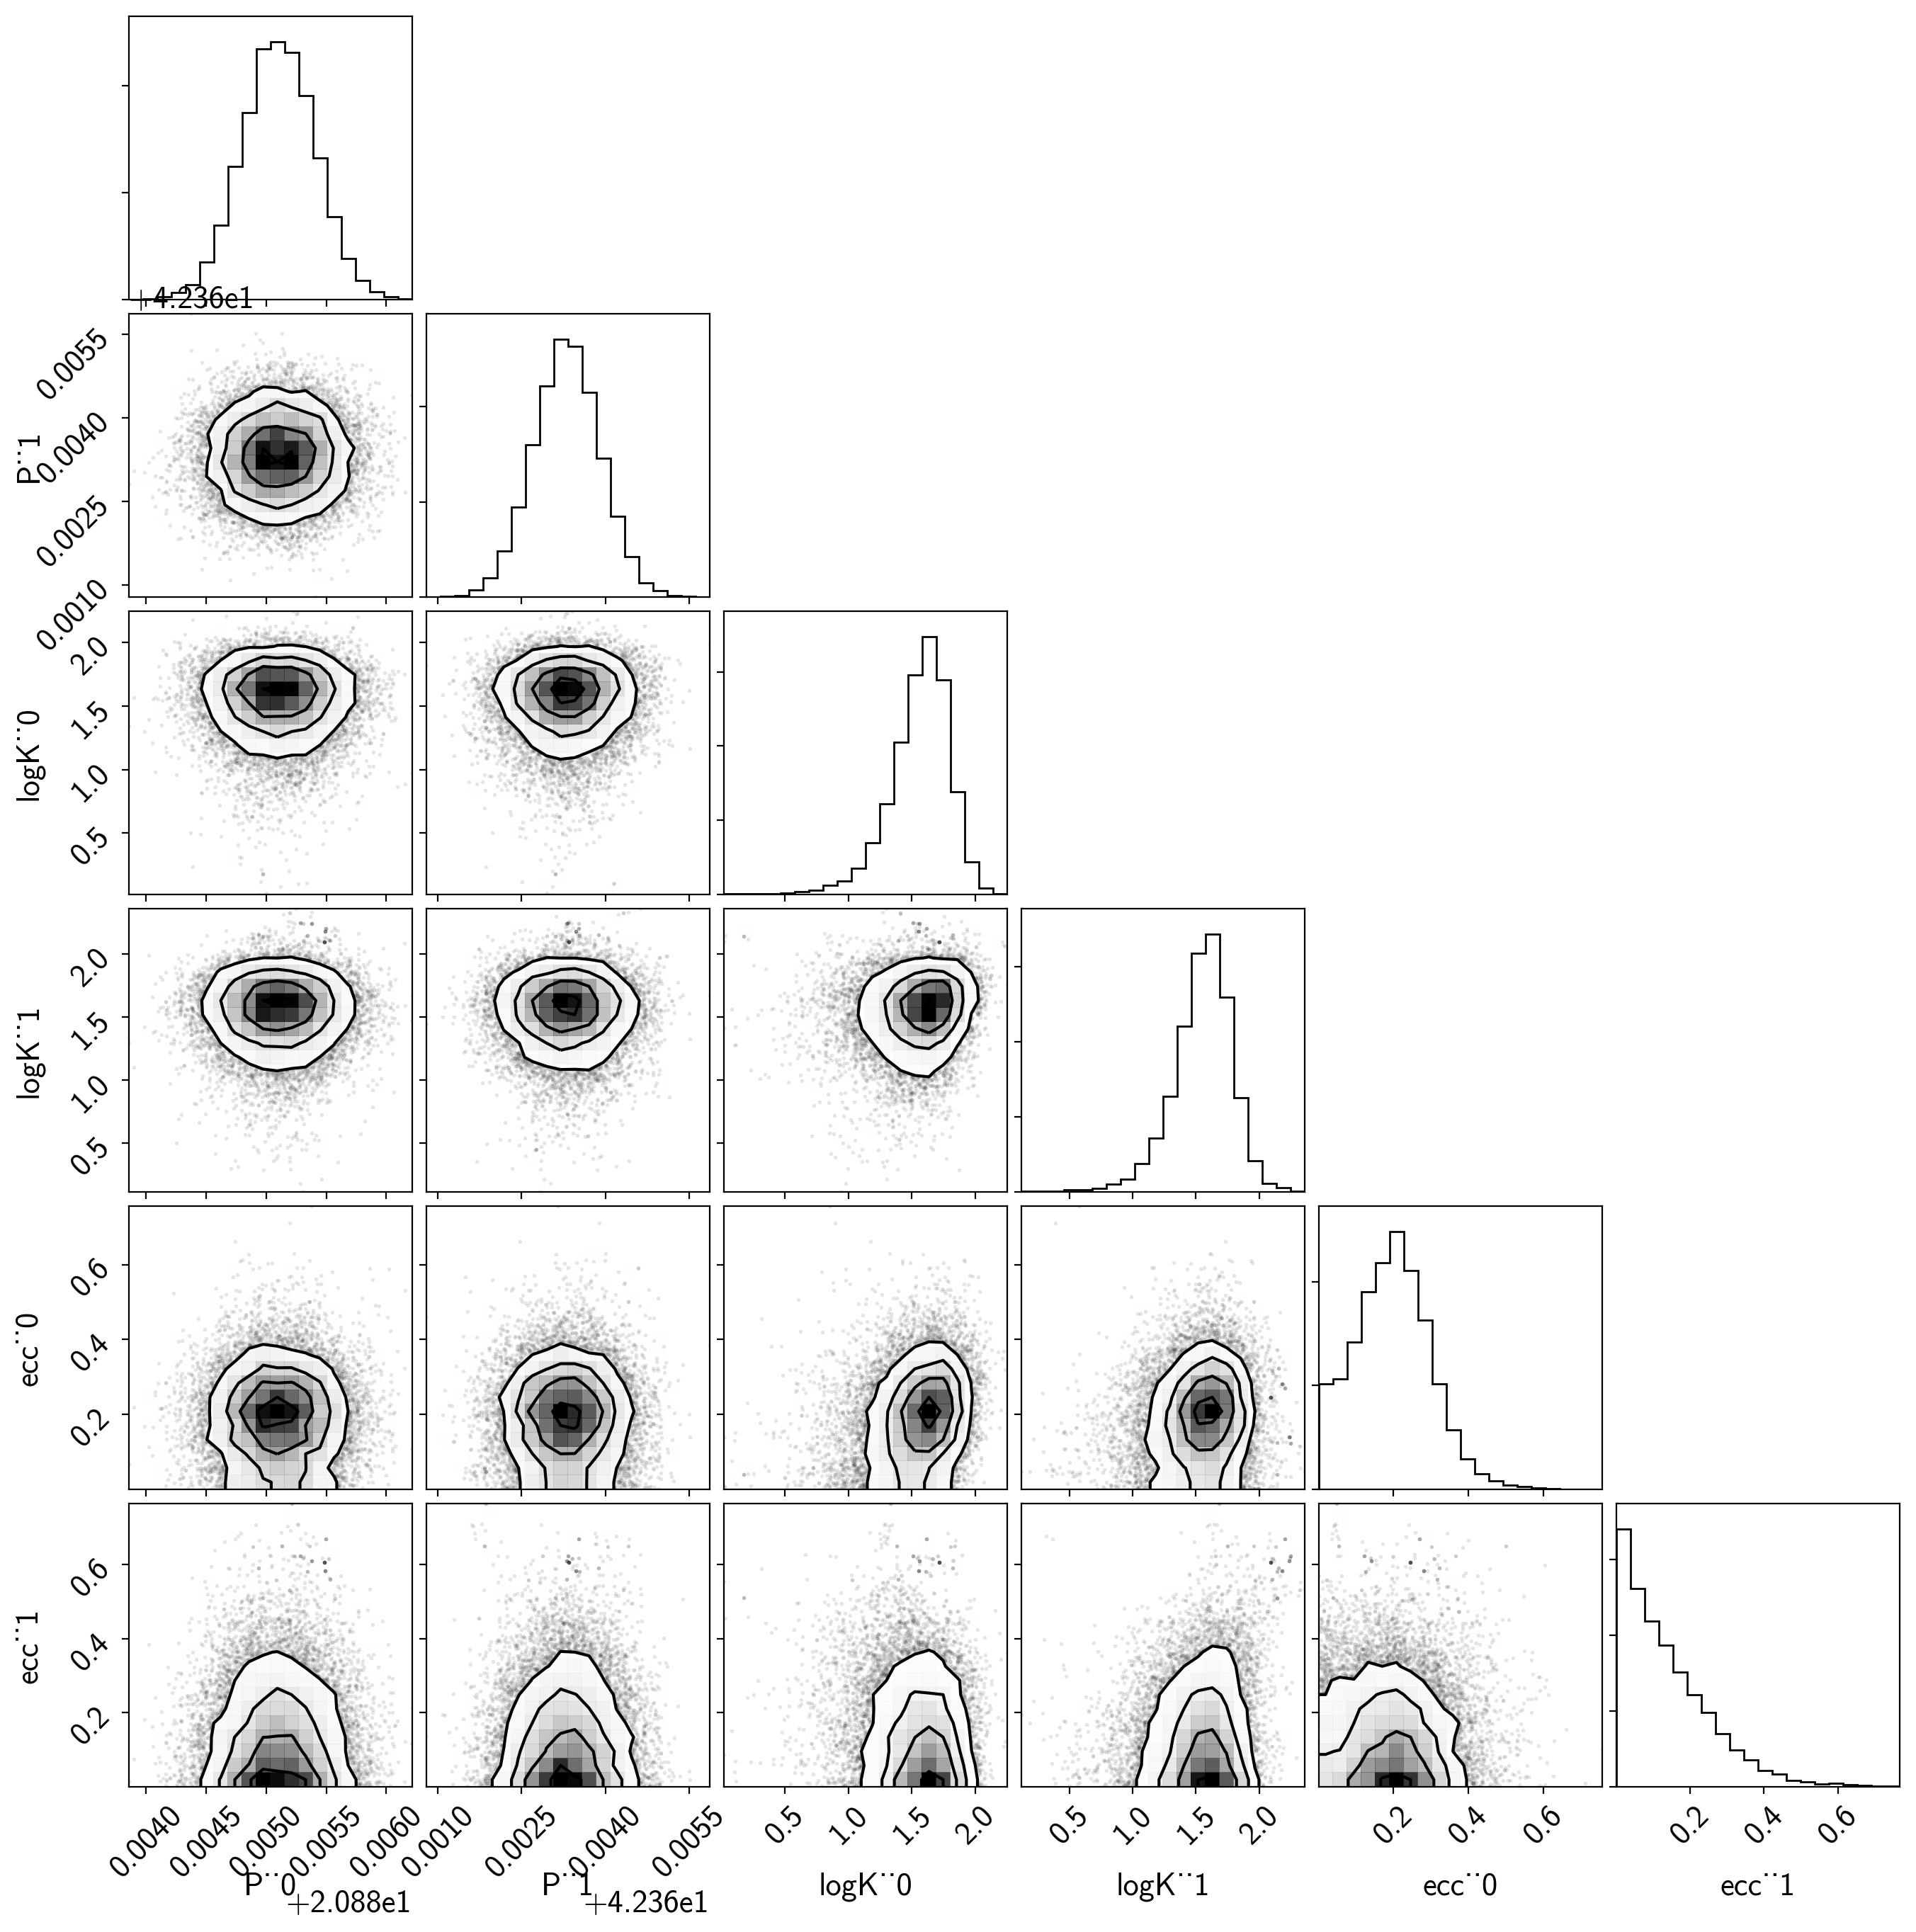

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

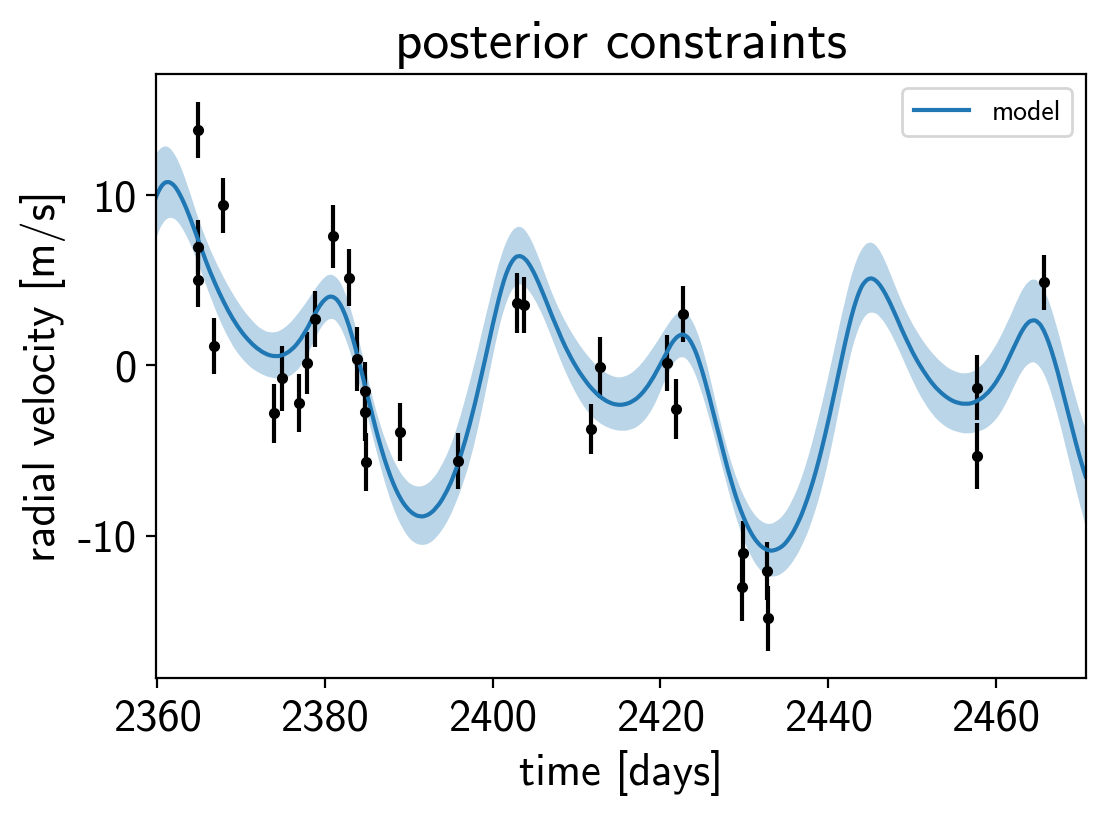

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

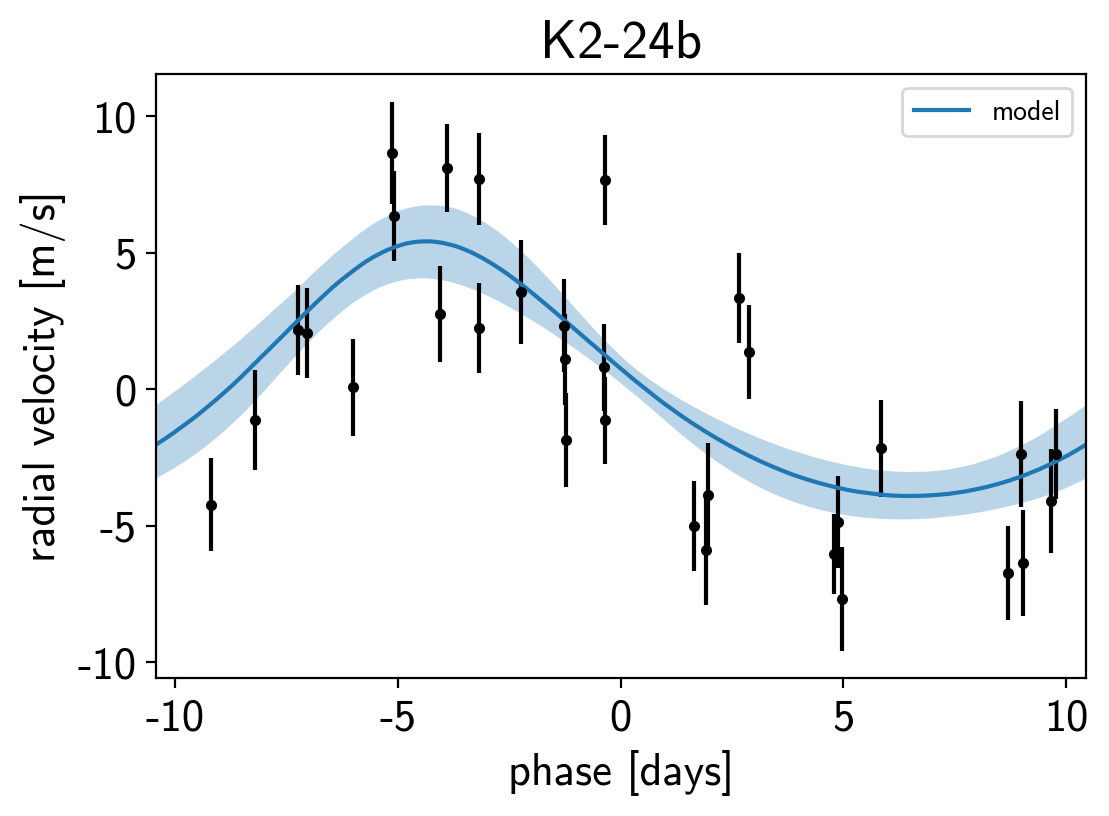

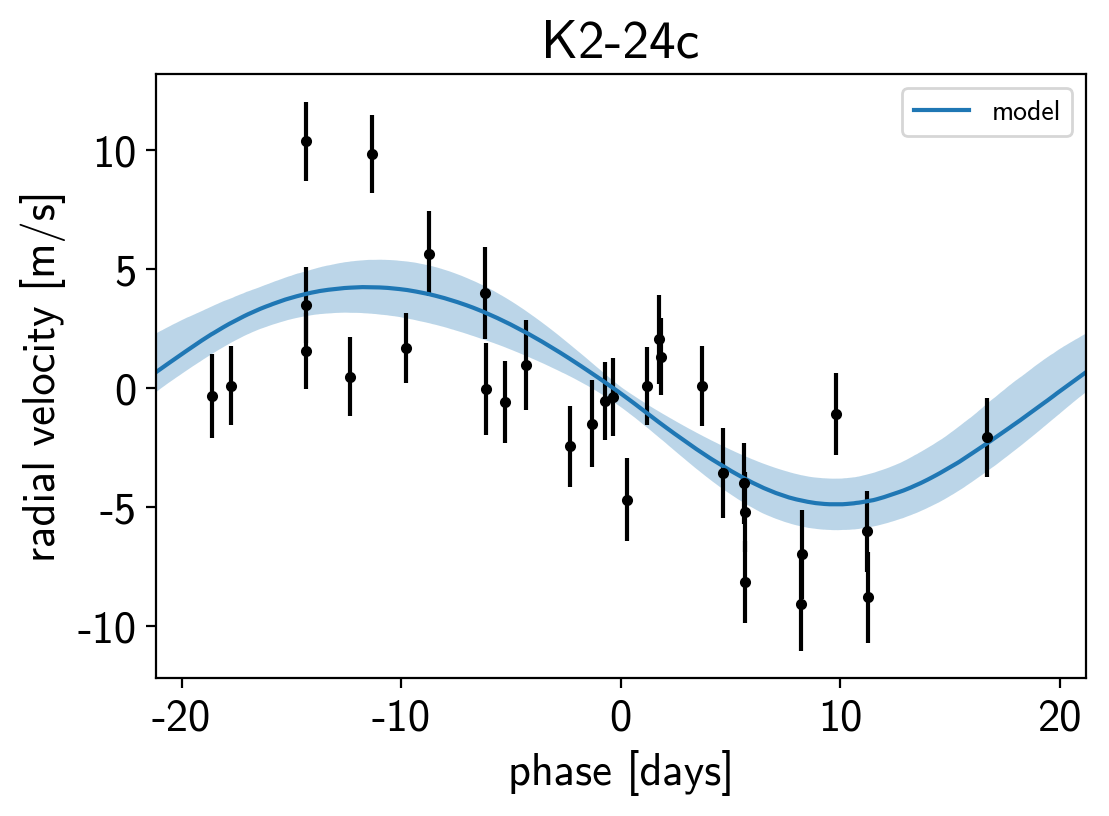

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [17]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
...
